[View in Colaboratory](https://colab.research.google.com/github/LjBLincoln/Machine_Learning/blob/master/wxplusb.ipynb)

# **Create Train Data and Test Data**

In [0]:
import os

import numpy as np 

TRAIN_DATA = 800
TEST_DATA = 200

TRAIN_DATA_FILE = 'train'
TEST_DATA_FILE = 'test'

def create_DATA(file,type):
    if (os.path.isfile(file)):
        x_data = np.loadtxt(file)
    else:
        X = np.random.rand(type).astype(np.float32)
        x_data = np.array([X,np.random.uniform(0,3, type) + X]).reshape(type,2)
        np.savetxt(file,x_data)
    
    #print(x_data)

create_DATA(TRAIN_DATA_FILE,TRAIN_DATA)
create_DATA(TEST_DATA_FILE,TEST_DATA)

# **Create TFRecord **

In [0]:
# -*- coding: utf-8 -*-
import os 
import tensorflow as tf

TRAIN_DATA_FILE = 'train'
TEST_DATA_FILE = 'test'

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))
  
def create_TFRecord(file):
    classes = np.loadtxt(file)
    #print(classes) 
    writer = tf.python_io.TFRecordWriter(file +'.tfrecords')

    for index, data in enumerate(classes):
        #print(index,data[0],data[1]) 
        example = tf.train.Example(features = tf.train.Features(feature = {"y_data": _float_feature(data[1]),
                                                                           "x_data": _float_feature(data[0]),                                                                          
                                                                            }))
        writer.write(example.SerializeToString()) 
    writer.close()
  
create_TFRecord(TRAIN_DATA_FILE)
create_TFRecord(TEST_DATA_FILE)

# **Read TFRecord **

## **Methord-One**

In [3]:
'''import tensorflow as tf


def read_and_decode_one(filename, batch_size): # read train.tfrecords
    filename_queue = tf.train.string_input_producer([filename])# create a queue

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)#return file_name and file
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'x_data': tf.FixedLenFeature([], tf.float32),
                                           'y_data' : tf.FixedLenFeature([], tf.float32),
                                       })#return image and label

    X_ = tf.cast(features['x_data'], tf.float32)
    Y_ = tf.cast(features['y_data'], tf.float32) 

    x_batch, y_batch = tf.train.shuffle_batch([X_, Y_],
                                                    batch_size= batch_size,
                                                    num_threads=64,
                                                    capacity=2000,
                                                    min_after_dequeue=1500,
                                                    )
    print(x_batch)
    print(y_batch)
    return x_batch, tf.reshape(y_batch,[batch_size])
'''

"import tensorflow as tf\n\n\ndef read_and_decode_one(filename, batch_size): # read train.tfrecords\n    filename_queue = tf.train.string_input_producer([filename])# create a queue\n\n    reader = tf.TFRecordReader()\n    _, serialized_example = reader.read(filename_queue)#return file_name and file\n    features = tf.parse_single_example(serialized_example,\n                                       features={\n                                           'x_data': tf.FixedLenFeature([], tf.float32),\n                                           'y_data' : tf.FixedLenFeature([], tf.float32),\n                                       })#return image and label\n\n    X_ = tf.cast(features['x_data'], tf.float32)\n    Y_ = tf.cast(features['y_data'], tf.float32) \n\n    x_batch, y_batch = tf.train.shuffle_batch([X_, Y_],\n                                                    batch_size= batch_size,\n                                                    num_threads=64,\n                                 

## **Methord-Two**

In [4]:
import tensorflow as tf

from tensorflow.contrib.learn.python.learn.datasets import base


def pares_tfrecorder(serialized_example):
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'x_data': tf.FixedLenFeature([], tf.float32),
                                           'y_data' : tf.FixedLenFeature([], tf.float32),
                                       })

    X_ = tf.cast(features['x_data'], tf.float32)
    Y_ = tf.cast(features['y_data'], tf.float32) 

    return X_,Y_

def read_and_decode_two(filename,batch):
    dataset = tf.data.TFRecordDataset(filename)
    #print(dataset)
    dataset = dataset.map(pares_tfrecorder)
    dataset = dataset.batch(batch).repeat(1)
    
    return dataset

'''
tfrecords_file = 'train.tfrecords'

BATCH_SIZE = 20
data = read_and_decode(tfrecords_file,BATCH_SIZE)

iterator = data.make_one_shot_iterator()

Xs,Ys = iterator.get_next()

print(Xs,Ys)

with tf.Session() as sess:
  print(sess.run([Xs,Ys]))
'''

"\ntfrecords_file = 'train.tfrecords'\n\nBATCH_SIZE = 20\ndata = read_and_decode(tfrecords_file,BATCH_SIZE)\n\niterator = data.make_one_shot_iterator()\n\nXs,Ys = iterator.get_next()\n\nprint(Xs,Ys)\n\nwith tf.Session() as sess:\n  print(sess.run([Xs,Ys]))\n"

# **Show TFRecords**

In [5]:
'''
import numpy as np 

tfrecords_file = 'train.tfrecords'

BATCH_SIZE = 8
x_batch, y_batch = read_and_decode_one(tfrecords_file, BATCH_SIZE)
#print(x_batch)
#print(y_batch)
with tf.Session()  as sess:

    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    try:
        while not coord.should_stop() and i<1:
            # just plot one batch size
            x, y = sess.run([x_batch, y_batch])
            for j in np.arange(BATCH_SIZE):
                print(y_batch)
                print(y)
            i+=1
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)
'''

"\nimport numpy as np \n\ntfrecords_file = 'train.tfrecords'\n\nBATCH_SIZE = 8\nx_batch, y_batch = read_and_decode_one(tfrecords_file, BATCH_SIZE)\n#print(x_batch)\n#print(y_batch)\nwith tf.Session()  as sess:\n\n    i = 0\n    coord = tf.train.Coordinator()\n    threads = tf.train.start_queue_runners(coord=coord)\n\n    try:\n        while not coord.should_stop() and i<1:\n            # just plot one batch size\n            x, y = sess.run([x_batch, y_batch])\n            for j in np.arange(BATCH_SIZE):\n                print(y_batch)\n                print(y)\n            i+=1\n    except tf.errors.OutOfRangeError:\n        print('done!')\n    finally:\n        coord.request_stop()\n    coord.join(threads)\n"

# Demo (y = wx+b)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
After 0  step(s), loss is 0.120682, weight is 0.870574 , bias is 0.00906082
After 50  step(s), loss is 0.0849602, weight is 0.507788 , bias is 0.197758
After 100  step(s), loss is 0.075408, weight is 0.315682 , bias is 0.289045
After 150  step(s), loss is 0.0728205, weight is 0.215698 , bias is 0.336556
After 200  step(s), loss is 0.0721195, weight is 0.16366 , bias is 0.361283
After 250  step(s), loss is 0.0719297, weight is 0.136576 , bias is 0.374153
After 300  step(s), loss is 0.0718783, weight is 0.12248 , bias is 0.380851
After 350  step(s), loss is 0.0718643, weight is 0.115143 , bias is 0.384338
After 400  step(s), loss is 0.0718606, weight is 0.111325 , bias is 0.386152
After 450  step(s), loss is 0.0718595, weight is 0.109338 , bias is 0.387096
After 500  step(s), loss is 0.0718593, weight is 0.108303 , bias is 0.387588


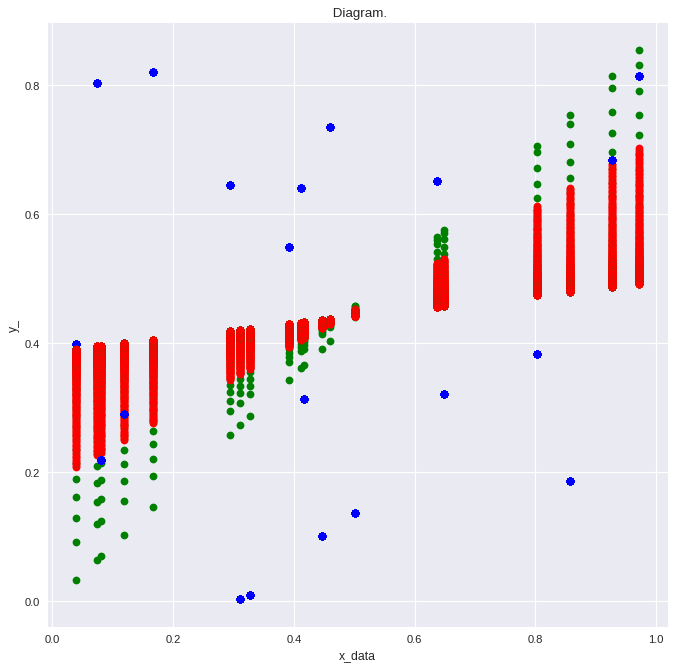

Done !!!


In [6]:
# _*_ coding: utf-8 _*_

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

import os

BATCH_SIZE = 20

TRAIN_TF_REDOCRD_FILE = 'train.tfrecords'
TEST_TF_REDOCRD_FILE = 'test.tfrecords'

MAX_STEPS = 500

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/test_model.ckpt'


#input
with tf.name_scope('input'):
    with tf.name_scope('x'):
        x = tf.placeholder(tf.float32, shape = (BATCH_SIZE,), name = "x")
        #print(x)
    with tf.name_scope('y_'):
        y_ = tf.placeholder(tf.float32, shape = (BATCH_SIZE,), name = "y_")

        
# layer
with tf.name_scope('layer'):
    with tf.name_scope('weights'):
        ###对权进行赋值 在-1到1之间随机数
        Weights = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
        tf.summary.histogram('Weights' ,Weights)
    with tf.name_scope('biases'):
        #初始偏差为零
        biases = tf.Variable(tf.zeros([1]))
        tf.summary.histogram('biases' ,biases)
    with tf.name_scope('Wx_plus_b'):
        #权值与x相乘并加偏差
        y = Weights * x + biases 

#Mean Squared Error)
with tf.name_scope('Mean_Squared_Error'):
    #方差，(y-y_)平方，求和，取均值
    loss = tf.reduce_mean(tf.square(y-y_),name='loss')
    tf.summary.scalar('loss', loss)
    
#Optimizer
with tf.name_scope('train'):
    #定义梯度下降法优化函数优化，步长为0.5
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    #tf.summary.scalar('optimizer', optimizer)
    train_step = optimizer.minimize(loss)

  
def feed_dict(train,batch_sieze):
    #xs, ys =x_data[0], x_data[1]
    if train:
      data = read_and_decode_two(TRAIN_TF_REDOCRD_FILE,batch_sieze)
    else :
      data = read_and_decode_two(TEST_TF_REDOCRD_FILE,batch_sieze)

    next_element = data.make_one_shot_iterator().get_next()

    return next_element

#Xs,Ys = feed_dict(True,BATCH_SIZE)

merged = tf.summary.merge_all()

step = 0

#session
with  tf.Session() as sess:
  
    init = tf.global_variables_initializer()
    
    #create FileWriter and loadd graph
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

    sess.run(init)
    
    plt.figure(figsize=(10, 10), dpi=80)
    plt.ion()

    #Save
    saver = tf.train.Saver()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    try:
        while not coord.should_stop() and  step <= MAX_STEPS:
            x_data ,y_data = sess.run(fetches=feed_dict(True,BATCH_SIZE))
            plt.title(" Diagram.")
            plt.xlabel("x_data")
            plt.ylabel("y_")
            plt.plot(x_data,y_data,'ro',color='b',linewidth=0.5)

            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            
            #print(x_data) 
            #print(y_data)
        
            summary,y_re,loss_value, _ = sess.run([merged,y,loss,train_step],feed_dict={x:x_data,y_:y_data},options=run_options)
        
            train_writer.add_summary(summary, step)
        
             #print(feed_dict())
            if step % 50 == 0:
                print("After %d  step(s), loss is %g, weight is %g , bias is %g" %(step, loss_value,sess.run(Weights),sess.run(biases)))
                saver.save(sess,MODELS_DIR, global_step=step)
    
    
            if step % 10 == 0:
                plt.plot(x_data,y_re,'ro', color='g',linewidth=0.5)
            if loss_value <= 0.0863299:
                plt.plot(x_data,y_re,'ro', color='r',linewidth=0.5)
            step += 1
            
            #if step > MAX_STEPS :
            #    freeze_graph(MODELS_DIR)

    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)

    plt.ioff()
    plt.show()
    
    #close FileWriter
    train_writer.close()


print("Done !!!")




# **Freeze Graph**

In [7]:
from tensorflow.python.framework import graph_util

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/'

def freeze_graph(model_folder,modelsName):
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    #print(checkpoint)
    #print(input_checkpoint)
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder + "/"+modelsName+".pb"
    #print(absolute_model_folder)
    #print(output_graph)
    
    output_node_names = "Mean_Squared_Error/sub" #now is bad!!!!
    
    clear_devices = True
    
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)
    #print(saver)
    
    graph = tf.get_default_graph()
    
    input_graph_def = graph.as_graph_def()
    
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)
 
        # We use a built-in TF helper to export variables to constant
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, 
            input_graph_def, 
            output_node_names.split(",") # We split on comma for convenience
        ) 
 
        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))
    
    
with tf.Session() as sess:
    freeze_graph(MODELS_DIR,'test')
    #print(MODELS_DIR)

INFO:tensorflow:Restoring parameters from ./log/models/test_model.ckpt-500
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.
9 ops in the final graph.


# **Load pb Model**

In [8]:
import argparse
import os
import sys

import tensorflow as tf
from tensorflow.python.platform import gfile

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/'

def load(MODELS_DIR,fileName):
  graph = tf.get_default_graph()
  graphdef = graph.as_graph_def()
  graphdef.ParseFromString(gfile.FastGFile(MODELS_DIR+fileName, "rb").read())
  _ = tf.import_graph_def(graphdef, name="")
  summary_write = tf.summary.FileWriter(LOG_DIR + '/graph', graph)
  summary_write.close()


load(MODELS_DIR,'test.pb')



Instructions for updating:
Use tf.gfile.GFile.


# **TensorBoard**

In [9]:
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



--2018-10-24 09:55:42--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.87.35.92, 54.173.32.212, 54.164.206.44, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.87.35.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  8.85MB/s    in 0.6s    

2018-10-24 09:55:44 (8.85 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://97de9e93.ngrok.io


# **Test Numpy**

In [10]:
'''import matplotlib.pyplot as plt

import numpy as np

MAX_STEPS = 500

NUM_EXAMPLES = 10000

# create data 生成100个0-1之间的随机数   np.random.rand(100) 1*100的矩阵，其每个元素为0-1的随机数
#x_data = np.random.rand(NUM_EXAMPLES).astype(np.float32)

#y_data = x_data

#x_data =np.array([np.random.uniform(1,1.2, NUM_EXAMPLES),np.random.uniform(1,1.2, NUM_EXAMPLES)]) #np.array([np.linspace(1, 4, NUM_EXAMPLES), np.linspace(3, 9, NUM_EXAMPLES)])
X = np.random.rand(NUM_EXAMPLES).astype(np.float32)
#print(X)
x_data = np.array([X,np.random.uniform(0,1, NUM_EXAMPLES)] + X ).reshape(NUM_EXAMPLES,2)
print(x_data)

plt.figure(figsize=(10, 10), dpi=80)
plt.ion()
plt.title(" Diagram.")
plt.xlabel("x_data")
plt.ylabel("y_")
#plt.xlim(xmax=1, xmin=0)
#plt.ylim(ymax=1,ymin=0)
plt.plot(x_data[0:1],x_data[0:1],'ro',color='r',linewidth=0.5)
plt.ioff()
plt.show()'''

'import matplotlib.pyplot as plt\n\nimport numpy as np\n\nMAX_STEPS = 500\n\nNUM_EXAMPLES = 10000\n\n# create data 生成100个0-1之间的随机数   np.random.rand(100) 1*100的矩阵，其每个元素为0-1的随机数\n#x_data = np.random.rand(NUM_EXAMPLES).astype(np.float32)\n\n#y_data = x_data\n\n#x_data =np.array([np.random.uniform(1,1.2, NUM_EXAMPLES),np.random.uniform(1,1.2, NUM_EXAMPLES)]) #np.array([np.linspace(1, 4, NUM_EXAMPLES), np.linspace(3, 9, NUM_EXAMPLES)])\nX = np.random.rand(NUM_EXAMPLES).astype(np.float32)\n#print(X)\nx_data = np.array([X,np.random.uniform(0,1, NUM_EXAMPLES)] + X ).reshape(NUM_EXAMPLES,2)\nprint(x_data)\n\nplt.figure(figsize=(10, 10), dpi=80)\nplt.ion()\nplt.title(" Diagram.")\nplt.xlabel("x_data")\nplt.ylabel("y_")\n#plt.xlim(xmax=1, xmin=0)\n#plt.ylim(ymax=1,ymin=0)\nplt.plot(x_data[0:1],x_data[0:1],\'ro\',color=\'r\',linewidth=0.5)\nplt.ioff()\nplt.show()'

# **Tensorboard Projector**

In [11]:
'''import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

LOG_DIR = './'
NAME_TO_VISUALISE_VARIABLE = "mnistembedding"
TO_EMBED_COUNT = 500


path_for_mnist_sprites ='mnistdigits.png'  #os.path.join(LOG_DIR,'mnistdigits.png')
path_for_mnist_metadata ='metadata.tsv'  #os.path.join(LOG_DIR,'metadata.tsv')

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
batch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)

embedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_mnist_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_mnist_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)


def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))


    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img

    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits
to_visualise = batch_xs
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(path_for_mnist_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

with open(path_for_mnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index,label))
print("Done !!!")

#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"'''

'import matplotlib.pyplot as plt\nimport tensorflow as tf\nimport numpy as np\nimport os\n\nfrom tensorflow.contrib.tensorboard.plugins import projector\nfrom tensorflow.examples.tutorials.mnist import input_data\n\nLOG_DIR = \'./\'\nNAME_TO_VISUALISE_VARIABLE = "mnistembedding"\nTO_EMBED_COUNT = 500\n\n\npath_for_mnist_sprites =\'mnistdigits.png\'  #os.path.join(LOG_DIR,\'mnistdigits.png\')\npath_for_mnist_metadata =\'metadata.tsv\'  #os.path.join(LOG_DIR,\'metadata.tsv\')\n\nmnist = input_data.read_data_sets("MNIST_data/", one_hot=False)\nbatch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)\n\nembedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALISE_VARIABLE)\nsummary_writer = tf.summary.FileWriter(LOG_DIR)\n\nconfig = projector.ProjectorConfig()\nembedding = config.embeddings.add()\nembedding.tensor_name = embedding_var.name\n\n# Specify where you find the metadata\nembedding.metadata_path = path_for_mnist_metadata #\'metadata.tsv\'\n\n# Specify where you find the sprite 